In [1]:
from tqdm import tqdm
import csv
import numpy as np
import cv2
import pandas as pd
import os
from glob import glob
import json
from collections import namedtuple, OrderedDict
import matplotlib.pyplot as plt
import shutil
import time

In [2]:
img_dir = "/mnt/sda/svs_workspace/PID/Digitized_PID/DigitizePID_Dataset/image_2/"
csv_path = "/mnt/sda/svs_workspace/PID/Digitized_PID/digitized_labels.csv"
# csv_path = "/mnt/sda/svs_workspace/PID/Digitized_PID/digitized_labels.csv"
# csv_path = "/mnt/sda/svs_workspace/PID/Digitized_PID/digitized_words_labels.csv"
sub_folder = "Symbols/1280_full/"
folder_path = "/mnt/sda/svs_workspace/PID/Digitized_PID/Cropped_datasets/" + sub_folder
stop_counter = 501

viz_dir = folder_path + "image_crops_viz/"
img_out_dir = folder_path + "image_crops/"
out_csv= folder_path + "crop_annotations.csv"

# CROP_SIZE = 1024
# CROP_STRIDE = 896

# CROP_SIZE = 2048
# CROP_STRIDE = 1792

# CROP_SIZE = 4096
# CROP_STRIDE = 3584

CROP_SIZE = 1280
CROP_STRIDE = 960

# CROP_SIZE = 512
# CROP_STRIDE = 384

In [3]:
dirs_to_create = [img_out_dir, viz_dir]

for d in dirs_to_create:
    if os.path.exists(d) and os.path.isdir(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

In [4]:
def add_columns(df):
    
    df = df.dropna()
    df = df[df.region_count != 0]

    df['bbox_json'] = df['region_shape_attributes'].apply(json.loads)

    df['x'] = df['bbox_json'].apply(lambda x: x['x'])
    df['y'] = df['bbox_json'].apply(lambda x: x['y'])
    df['width'] = df['bbox_json'].apply(lambda x: x['width'])
    df['height'] = df['bbox_json'].apply(lambda x: x['height'])
#     df['classname'] = df['region_attributes'].apply(json.loads).apply(lambda x: "Text")
    df['classname'] = df['region_attributes'].apply(json.loads).apply(lambda x: x['name'])

    return df

def group_by_filename(df, group='filename'):
    
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [5]:
df = pd.read_csv(csv_path)
# df = add_columns(df)
print(df.head())
groups = group_by_filename(df)

  filename     x     y  width  height  classname
0    0.jpg  1669   767     33      62         21
1    0.jpg  1752   723     62      32         21
2    0.jpg  1182  2011     62      33         21
3    0.jpg  2556  3333     33      62         21
4    0.jpg  3930  1622     32      62         21


In [6]:

# for i in range(100000):
#     new_row = {
#         'filename': ["crop_name"], 
#     #                         'file_size': [os.path.getsize(os.path.join(img_out_dir, crop_name))], 
#     #                         'file_attributes': [row.file_attributes], 
#         'x': [25], 
#         'y': [25555], 
#         'width': [5656], 
#         'height': [676767],
#         'classname': [0],
#     #                         'class_description': [row.class_description]
#     }

#     new_row_df = pd.DataFrame(new_row)
#     new_df = new_df.append(new_row_df, ignore_index=True)


# print(time.time() - t1)
# new_df.to_csv("./test.csv",index=False ,mode='a',header=False)

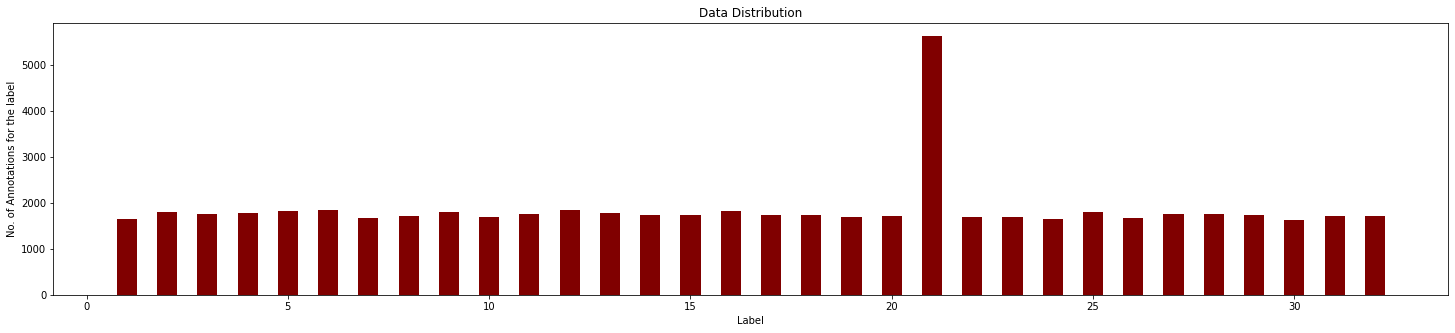

In [7]:
a, b = np.unique(df['classname'], return_counts=True)
# for c, co in zip(a, b):
#     print(c, co)

fig = plt.figure(figsize = (25, 5))

# creating the bar plot
plt.bar(a, b, color ='maroon',
        width = 0.5)
 
plt.xlabel("Label")
plt.ylabel("No. of Annotations for the label")
plt.title("Data Distribution")
plt.show()

In [8]:
def get_iou(window_bbox, object_bbox):
    
    (w_x, w_y, w_w, w_h) = window_bbox
    (o_x, o_y, o_w, o_h) = object_bbox

    curr_x = 0
    curr_y = 0
    curr_w = 0
    curr_h = 0
    o_x2 = o_x+o_w
    o_y2 = o_y+o_h
    w_x2 = w_x + w_w
    w_y2 = w_y + w_h
    
    if(o_x>=w_x2 or o_x2<=w_x or o_y>=w_y2 or o_y2<=w_y):
        pass
    else:
        if(o_x>=w_x and o_x2<=w_x2):
            curr_x = o_x - w_x
            curr_w = o_w
        elif(o_x<=w_x and o_x2>w_x and o_x2<=w_x2):
            curr_x = 0
            curr_w = o_x2 - w_x
        elif(o_x>=w_x and o_x<w_x2 and o_x2>=w_x2):
            curr_x = o_x - w_x
            curr_w = w_x2 - o_x
        
        if(o_y>=w_y and o_y2<=w_y2):
            curr_y = o_y - w_y
            curr_h = o_h
        elif(o_y<=w_y and o_y2>w_y and o_y2<=w_y2):
            curr_y = 0
            curr_h = o_y2 - w_y
        elif(o_y>=w_y and o_y<w_y2 and o_y2>=w_y2):
            curr_y = o_y - w_y
            curr_h = w_y2 - o_y
    
    iou_object = (curr_w*curr_h) / (o_w*o_h)
#     print([curr_x,curr_y,curr_w,curr_h], iou_object)
    return [curr_x,curr_y,curr_w,curr_h], iou_object

In [9]:
import time
t1 = time.time()

new_df = pd.DataFrame(columns=df.columns)
# new_df = new_df.drop(columns=['region_count', 'region_attributes', 'region_id', 'region_shape_attributes', 'bbox_json','file_size'])
print(new_df.columns)

if(os.path.exists(out_csv)):
    print("Deleting existing csv file")
    os.remove(out_csv)

new_df.to_csv(out_csv,index=False)
df_counter = 0

counter = 0
for group in tqdm(groups, desc="Images",position=0):
    if(counter>=stop_counter):
        break
    counter+=1
    filename = group.filename
    image = cv2.imread(os.path.join(img_dir, filename))
    if image is None:
        continue
#     if "18" not in filename:
#         continue
    image_df = group.object
    image_h, image_w, _ = image.shape
    
    for window_start_x in range(0, image_w - CROP_SIZE, CROP_STRIDE):
        for window_start_y in range(0, image_h - CROP_SIZE, CROP_STRIDE):
            window_end_x = window_start_x + CROP_SIZE
            window_end_y = window_start_y + CROP_SIZE
            
            img_crop = image[window_start_y:window_end_y, window_start_x:window_end_x, :]
            viz_crop = np.copy(img_crop)
            crop_name = f"{filename[:-4]}_{window_start_x}_{window_start_y}.png"
            atleast_one_annotation = False
            for row_num, row in image_df.iterrows():
                x, y, w, h, classname = row.x, row.y, row.width, row.height, row.classname
                
                row_xmax = row.x + row.width
                row_ymax = row.y + row.height

                if (row.x >= window_start_x and row.x <= window_end_x) and \
                    (row.y >= window_start_y and row.y <= window_end_y):
                    pass
                elif (row_xmax >= window_start_x and row_xmax <= window_end_x) and \
                    (row_ymax >= window_start_y and row_ymax <= window_end_y):
                    pass
                elif (row.x >= window_start_x and row.x <= window_end_x) and \
                    (row_ymax >= window_start_y and row_ymax <= window_end_y):
                    pass
                elif (row_xmax >= window_start_x and row_xmax <= window_end_x) and \
                    (row.y >= window_start_y and row.y <= window_end_y):
                    pass
                else:
                    continue
                
                curr_cords, object_iou = get_iou((window_start_x, window_start_y, CROP_SIZE, CROP_SIZE),
                                              (x, y, w, h))
                
                if object_iou >= 0.90:
                    if(atleast_one_annotation==False):
                        atleast_one_annotation = True

                    new_row = {
                        'filename': [crop_name], 
#                         'file_size': [os.path.getsize(os.path.join(img_out_dir, crop_name))], 
#                         'file_attributes': [row.file_attributes], 
                        'x': [curr_cords[0]], 
                        'y': [curr_cords[1]], 
                        'width': [curr_cords[2]], 
                        'height': [curr_cords[3]],
                        'classname': [row.classname],
#                         'class_description': [row.class_description]
                    }

                    new_row_df = pd.DataFrame(new_row)
                    new_df = new_df.append(new_row_df, ignore_index=True)
                    if(df_counter==1000):
                        new_df.to_csv(out_csv,index=False,mode='a',header=False)
                        new_df = pd.DataFrame()
                        df_counter=0
                    df_counter+=1
                    viz_crop = cv2.rectangle(viz_crop, (curr_cords[0], curr_cords[1]), (curr_cords[0]+curr_cords[2], curr_cords[1]+curr_cords[3]),
                                         color=[0, 0, 255], thickness=3)

            if(atleast_one_annotation):
                cv2.imwrite(os.path.join(viz_dir, crop_name), viz_crop)
                cv2.imwrite(os.path.join(img_out_dir, crop_name), img_crop)
new_df.to_csv(out_csv,index=False,mode='a',header=False)
print(time.time() - t1)

Index(['filename', 'x', 'y', 'width', 'height', 'classname'], dtype='object')


Images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:45<00:00,  1.29s/it]

645.1868529319763
